In [4]:
# Reload all src modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import cProfile
import pandas as pd
import geopandas as geopd
import numpy as np
import multiprocessing as mp
import re
import gzip
try:
    import cld3
except ModuleNotFoundError:
    pass
import pycld2
from pyproj import Transformer
from shapely.geometry import Polygon
from shapely.geometry import Point
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes
import folium
import src.utils.geometry as geo
import src.data.shp_extract as shp_extract
import src.data.tweets_cells_counts as tweets_counts
import src.data.text_process as text_process
import src.data.access as data_access
import src.visualization.grid_viz as grid_viz
import src.data.user_filters as ufilters
from dotenv import load_dotenv
load_dotenv()

pd.reset_option("display.max_rows")

In [6]:
data_dir_path = os.environ['DATA_DIR']
tweets_files_format = 'tweets_2015_2018_{}.json.gz'
places_files_format = 'places_2015_2018_{}.json.gz'
ssh_domain = os.environ['IFISC_DOMAIN']
ssh_username = os.environ['IFISC_USERNAME']
country_codes = ('BO', 'CA', 'CH', 'EE', 'ES', 'FR', 'HK', 'ID', 'LT', 'LV',
                 'MY', 'PE', 'RO', 'SG', 'TN', 'UA')
latlon_proj = 'epsg:4326'
xy_proj = 'epsg:3857'
external_data_dir = '../data/external/'
fig_dir = '../reports/figures'
cc = 'CH'

In [7]:
places_file_path = os.path.join(data_dir_path, places_files_format.format(cc))
shapefile_name = 'CNTR_RG_01M_2016_4326.shp'
shapefile_path = os.path.join(
    external_data_dir, shapefile_name, shapefile_name)
shape_df = geopd.read_file(shapefile_path)
shape_df = shape_df.loc[shape_df['FID'] == cc]
country_name = shape_df['NAME_ENGL'].values[0]
raw_places_df = data_access.return_json(places_file_path,
                                        ssh_domain=ssh_domain, ssh_username=ssh_username, compression='gzip')
raw_places_df.head()

,attributes,bounding_box,country,country_code,full_name,id,name,place_type,url
0,{},"{'coordinates': [[[5.955894, 45.817792], [5.95...",Schweiz,CH,Suiza,4e7c21fd2af027c6,Suiza,country,https://api.twitter.com/1.1/geo/id/4e7c21fd2af...
1,{},"{'coordinates': [[[6.861601, 46.326441], [6.86...",Schweiz,CH,"Berne, Switzerland",5868d0e0749c9c47,Bern,admin,https://api.twitter.com/1.1/geo/id/5868d0e0749...
2,{},"{'coordinates': [[[9.400411, 47.496178], [9.40...",Schweiz,CH,"Arbon, Thurgau",99bc40068c24ecd8,Arbon,city,https://api.twitter.com/1.1/geo/id/99bc40068c2...
3,{},"{'coordinates': [[[6.127588, 46.168188], [6.12...",Schweiz,CH,"Carouge (GE), Genève",ddcca24ee29ddff2,Carouge (GE),city,https://api.twitter.com/1.1/geo/id/ddcca24ee29...
4,{},"{'coordinates': [[[9.491093, 46.750148], [9.49...",Schweiz,CH,"Churwalden, Graubünden",1a5f7565464884a4,Churwalden,city,https://api.twitter.com/1.1/geo/id/1a5f7565464...


Get rid of bots, company account (eg careerarc, tweetmyjobs). If can't distinguish companies by source like careerarc, then how?

## Getting the data

### Reading the data

In [8]:
tweets_file_path = os.path.join(data_dir_path, tweets_files_format.format(cc))

def pre_process(tweets_file_path, chunk_start, chunk_size):
    raw_tweets_df = data_access.read_json_wrapper(tweets_file_path, chunk_start, chunk_size, 
                                                  ssh_domain=ssh_domain, ssh_username=ssh_username)
    tweeted_months_users = ufilters.get_months_activity(raw_tweets_df)
    return raw_tweets_df, tweeted_months_users

def profile_pre_process(tweets_file_path, chunk_start, chunk_size):
    cProfile.runctx('pre_process(tweets_file_path, chunk_start, chunk_size)', globals(), locals())

agg_tweeted_months_users = pd.DataFrame([], columns=['uid', 'month'])
with mp.Pool(8) as pool:
    jobs = []
    for chunk_start, chunk_size in data_access.chunkify(tweets_file_path, size=1e9, 
                                                        ssh_domain=ssh_domain, ssh_username=ssh_username):
        jobs.append(pool.apply_async(pre_process, (tweets_file_path, chunk_start, chunk_size)))

    for job in jobs:
        raw_tweets_df, tweeted_months_users = job.get()
        agg_tweeted_months_users = pd.concat([agg_tweeted_months_users, tweeted_months_users])
total_nr_users = len(agg_tweeted_months_users['uid'].unique())
print('In total, there are {} distinct users in the whole dataset'.format(total_nr_users))

1000MB read, 846686 tweets unpacked.
There are 53407 distinct users in the dataset.
1000MB read, 852716 tweets unpacked.
There are 58668 distinct users in the dataset.
1000MB read, 844912 tweets unpacked.
There are 50895 distinct users in the dataset.
1000MB read, 841957 tweets unpacked.
There are 47074 distinct users in the dataset.
1000MB read, 839053 tweets unpacked.
There are 54250 distinct users in the dataset.
1000MB read, 846221 tweets unpacked.
There are 52841 distinct users in the dataset.
1000MB read, 831641 tweets unpacked.
There are 57044 distinct users in the dataset.
1000MB read, 819327 tweets unpacked.
There are 51480 distinct users in the dataset.
798.3MB read, 649307 tweets unpacked.
There are 40586 distinct users in the dataset.
In total, there are 282734 distinct users in the whole dataset


In [9]:
local_uid_series = ufilters.consec_months(agg_tweeted_months_users)
crs = {'init': latlon_proj}
places_df = raw_places_df[['id', 'bounding_box', 'name', 'place_type']]
geometry = places_df['bounding_box'].apply(lambda x: Polygon(x['coordinates'][0]))
places_geodf = geopd.GeoDataFrame(places_df, crs=crs, geometry=geometry)
places_geodf = places_geodf.set_index('id')
places_geodf = places_geodf.drop(columns=['bounding_box'])
places_geodf['area'] = places_geodf.geometry.to_crs(xy_proj).area
print('done')

There are 59319 distinct users left in the dataset.
There are 38745 distinct users left in the dataset.
done


most tweets in the month in that country to asign local

3 times per hour on avergae over whole period -> bot

companies tweeting form places too far away -> get rid of them

### Processing

In [10]:
def process(job, local_uid_series, places_geodf, text_col='text', min_nr_words=4, cld='pycld2'):
    #     raw_tweets_df = job.get()[0]
    tweets_df = raw_tweets_df[[
        'text', 'id', 'lang', 'place_id', 'coordinates', 'uid', 'created_at', 'source']]
    tweets_df = tweets_df.loc[
        tweets_df['uid'].isin(local_uid_series.index.values)]
    tweets_df = tweets_df.rename(columns={'lang': 'twitter_lang'})
    print('starting lang detect')
    # put undefined when source=foursquare and startswith "I'm at ", both in twitter and cld lang
    tweets_lang_df = text_process.lang_detect(
        tweets_df, text_col='text', min_nr_words=4, cld='pycld2')
    tweets_lang_df = tweets_lang_df.loc[tweets_lang_df['cld_lang'] != 'un']
    tweets_to_loc_df = tweets_lang_df.loc[:]
    tweets_final_df = tweets_to_loc_df.join(
        places_geodf, on='place_id', how='left')
    print('processing done')
    return tweets_final_df


def profile_process(raw_tweets_df, local_uid_series, places_geodf):
    cProfile.runctx(
        'process(raw_tweets_df, local_uid_series, places_geodf)', globals(), locals())


list_tweets_df = []
with mp.Pool(8) as pool:
    results = []
#     raw_tweets_dfs = [job.get()[0] for job in jobs]
#     print('entering the loop')
#     for raw_tweets_df in raw_tweets_dfs:
    for job in jobs:
        raw_tweets_df = job.get()[0]
        results.append(pool.apply_async(
            process, (raw_tweets_df, local_uid_series, places_geodf)))

    for res in results:
        res.get()

starting lang detect
starting lang detect
starting lang detect
processing done
starting lang detect
processing done
starting lang detect
processing done
starting lang detect
processing done
starting lang detect
processing done
starting lang detect
processing done
starting lang detect
processing done
processing done
processing done


In [11]:
for res in results:
    df = res.get()
    print(df['source'].value_counts().head(10))

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>      183705
<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>     57426
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33209
<a href="http://instagram.com" rel="nofollow">Instagram</a>                              30219
<a href="https://www.careerarc.com" rel="nofollow">CareerArc 2.0</a>                     21814
<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>         8998
<a href="http://tapbots.com/tweetbot" rel="nofollow">Tweetbot for iΟS</a>                 8445
<a href="https://dlvrit.com/" rel="nofollow">dlvr.it</a>                                  1907
<a href="http://www.sotawatch.org/" rel="nofollow">SOTAwatch</a>                          1786
<a href="http://foursquare.com" rel="nofollow">Foursquare</a>                             1661
Name: source, dtype: int64
<a href="http://twitter

### Generate the grid

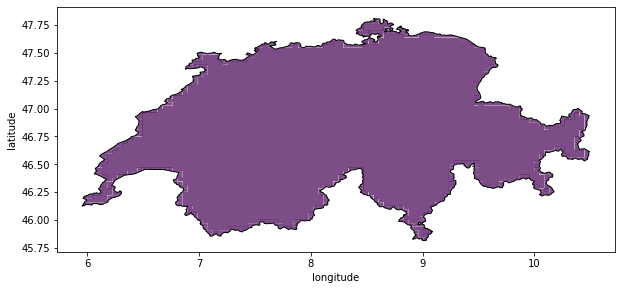

In [12]:
cell_size = 5000
cells_df, cells_in_area_df = geo.create_grid(shape_df, cell_size, latlon_proj, xy_proj, intersect=True)
grid_test_df = cells_in_area_df.copy()
grid_test_df['metric'] = 1
save_path = os.path.join(fig_dir, 'grid_cc={}_cell_size={}m.pdf'.format(cc, cell_size))
plot_kwargs = dict(alpha=0.7, edgecolor='w', linewidths=0.001)
ax = grid_viz.plot_grid(grid_test_df, shape_df, metric_col='metric', show=False, 
                        save_path=save_path, **plot_kwargs)

## One language tests

In [55]:
plot_lang = 'fr'
max_place_area = 1e9
agg_count_df = pd.Series(name='count', dtype='int64')
for res in results:
    df = res.get()
    df = df.loc[(df['area'] < max_place_area) & (df['cld_lang'] == plot_lang)]
    agg_count_df = tweets_counts.increment_counts(agg_count_df, df,
                                                 'place_id')
places_counts_df = places_geodf.join(agg_count_df, how='inner')
langs_dict = dict([(lang[1],lang[0].lower().capitalize()) for lang in pycld2.LANGUAGES])
print('There are {:n} tweets in {}.'.format(agg_count_df.sum(), langs_dict[plot_lang]))

There are 399600 tweets in French.


In [56]:
cells_in_area_df['cell_id'] = cells_in_area_df.index
count_lang_col = 'cell_count_{}'.format(plot_lang)
cells_intersect_places = geopd.overlay(places_counts_df, cells_in_area_df, how='intersection')
cells_intersect_places['area_intersect'] = cells_intersect_places.geometry.to_crs(xy_proj).area
cells_intersect_places[count_lang_col] = cells_intersect_places['count'] * (cells_intersect_places['area_intersect']
                                                                          / cells_intersect_places['area'])
cells_counts = cells_intersect_places.groupby('cell_id')[count_lang_col].sum()  
cell_plot_df = cells_in_area_df.join(cells_counts, how='left')
cell_plot_df[count_lang_col] = cell_plot_df[count_lang_col].fillna(value=0)

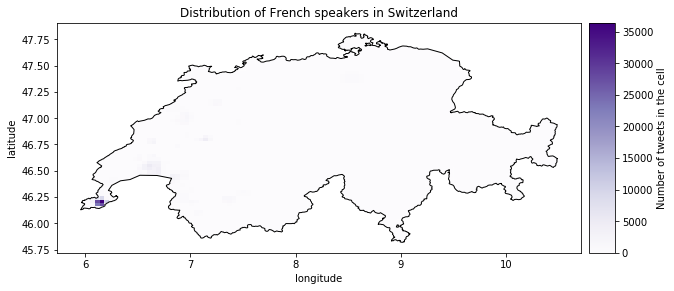

In [57]:
save_path = os.path.join(fig_dir, 
    'tweet_counts_cc={}_lang={}_cell_size={}m.pdf'.format(cc, plot_lang, cell_size))
country_name = shape_df['NAME_ENGL'].values[0]
plot_title = 'Distribution of {} speakers in {}'.format(langs_dict[plot_lang], country_name)
cbar_label = 'Number of tweets in the cell'
plot_kwargs = dict(edgecolor='w', linewidths=0.001, cmap='Purples')
ax = grid_viz.plot_grid(cell_plot_df, shape_df, metric_col=count_lang_col, save_path=save_path, 
                        title=plot_title, cbar_label=cbar_label, **plot_kwargs)

In [ ]:
plot_df = places_counts_df.copy()
plot_df['ratio'] = plot_df['count'] / plot_df['count'].max()
plot_kwargs = dict(alpha=0.7, edgecolor='w', linewidths=0.001)
ax = grid_viz.plot_grid(plot_df, shape_df, metric_col='ratio', **plot_kwargs)

## Study at the tweet level

### Make tweet counts data

In [50]:
langs_dict = dict([(lang[1],lang[0].lower().capitalize()) for lang in pycld2.LANGUAGES])
max_place_area = 1e9
plot_langs_list = ('fr', 'it', 'de')
plot_langs_dict = {}
cells_in_area_df['cell_id'] = cells_in_area_df.index
    
agg_counts = pd.Series(name='count', dtype='int64')
for res in results:
    tweets_final_df = res.get()
    relevant_area_mask = tweets_final_df['area'] < max_place_area
    tweets_final_df = tweets_final_df.loc[relevant_area_mask]
    agg_counts = tweets_counts.increment_counts(agg_counts, tweets_final_df, 'place_id')
    
places_counts_df = places_geodf.join(agg_counts, how='inner')
places_counts_df['place_id'] = places_counts_df.index
cells_intersect_places = geopd.overlay(places_counts_df, cells_in_area_df, how='intersection')
cells_intersect_places['area_intersect'] = cells_intersect_places.geometry.to_crs(xy_proj).area
cells_intersect_places['total_count'] = cells_intersect_places['count'] * (
        cells_intersect_places['area_intersect'] / cells_intersect_places['area'])
cells_intersect_places = cells_intersect_places.drop(columns=['count'])
# Here the index is lost because of the overlay (multiple cells intersect a place), that's why 
# we had to duplicate cells_in_area_df.index into the 'cell_id' column, to be able to make the groupby
total_cells_counts = cells_intersect_places.groupby('cell_id')['total_count'].sum()
data_in_cell_mask = cells_in_area_df['cell_id'].isin(total_cells_counts.index)
cell_plot_df = cells_in_area_df.loc[data_in_cell_mask, ['cell_id', 'geometry']]
cell_plot_df['total_count'] = total_cells_counts

    
for plot_lang in plot_langs_list:
    agg_counts = pd.Series(name='count', dtype='int64')
    for res in results:
        tweets_final_df = res.get()
        relevant_area_mask = tweets_final_df['area'] < max_place_area
        lang_mask = tweets_final_df['cld_lang'] == plot_lang
        tweets_final_df = tweets_final_df.loc[(relevant_area_mask) & (lang_mask)]
        agg_counts = tweets_counts.increment_counts(agg_counts, tweets_final_df, 'place_id')
    print('There are {:n} tweets in {}.'.format(agg_counts.sum(), langs_dict[plot_lang]))
    
    lang_dict = {}
    count_lang_col = 'cell_count_{}'.format(plot_lang)
    prop_lang_col = 'cell_prop_{}'.format(plot_lang)
    lang_dict['prop_col'] = prop_lang_col
    lang_dict['count_col'] = count_lang_col
    readable_lang = langs_dict[plot_lang]
    lang_dict['readable'] = readable_lang
    lang_dict['prop_label'] = 'Proportion of tweets in {} in the cell'.format(readable_lang)
    lang_dict['count_label'] = 'Number of tweets in {} in the cell'.format(readable_lang)
    plot_langs_dict[plot_lang] = lang_dict
    cells_intersect_places = cells_intersect_places.join(agg_counts, on='place_id', how='left')
    cells_intersect_places['count'] = cells_intersect_places['count'].fillna(value=0)
    cells_intersect_places[count_lang_col] = cells_intersect_places['count'] * (
        cells_intersect_places['area_intersect'] / cells_intersect_places['area'])
    cells_intersect_places = cells_intersect_places.drop(columns=['count'])
    
    lang_cells_counts = cells_intersect_places.groupby('cell_id')[count_lang_col].sum()
    cell_plot_df[count_lang_col] = lang_cells_counts 
    cell_plot_df[prop_lang_col] = cell_plot_df[count_lang_col] / cell_plot_df['total_count']

There are 399600 tweets in French.
There are 122796 tweets in Italian.
There are 664209 tweets in German.


### Static plots

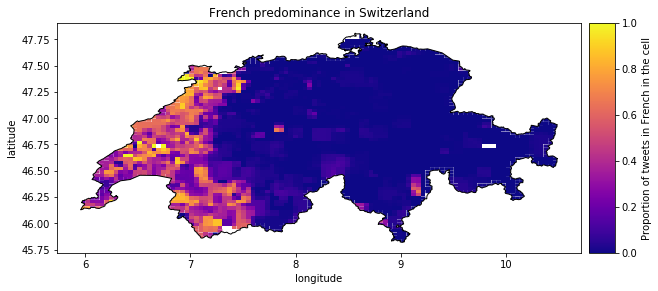

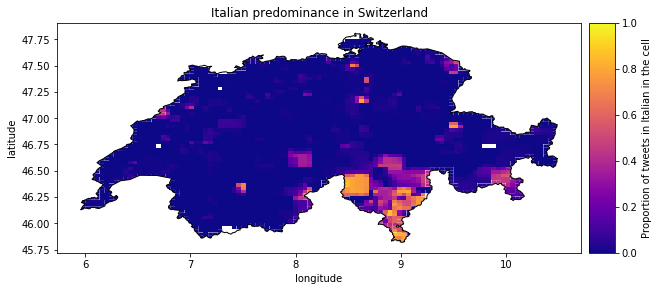

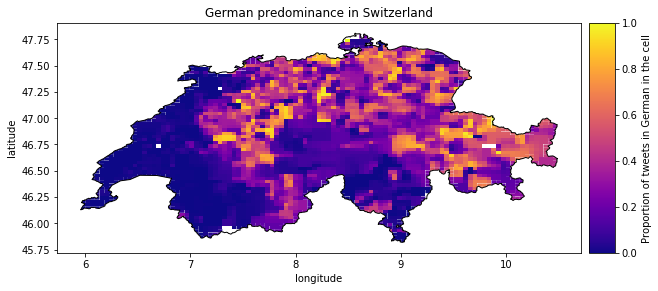

In [57]:
for plot_lang, plot_dict in plot_langs_dict.items():
    count_lang_col = plot_dict['count_col']
    readable_lang = plot_dict['readable']
    save_path = os.path.join(fig_dir, 
        'tweet_counts_cc={}_lang={}_cell_size={}m.pdf'.format(cc, plot_lang, cell_size))
    plot_title = 'Distribution of {} speakers in {}'.format(readable_lang, country_name)
    cbar_label = plot_dict['count_label']
    plot_kwargs = dict(edgecolor='w', linewidths=0.001, cmap='Purples')
    ax_count = grid_viz.plot_grid(cell_plot_df, shape_df, metric_col=count_lang_col, save_path=save_path, 
                                  show=False, log_scale=True, title=plot_title, 
                                  cbar_label=cbar_label, **plot_kwargs)
    
    prop_lang_col = plot_dict['prop_col']
    save_path = os.path.join(fig_dir, 
        'lang_prop_cc={}_lang={}_cell_size={}m.pdf'.format(cc, plot_lang, cell_size))
    plot_title = '{} predominance in {}'.format(readable_lang, country_name)
    cbar_label = plot_dict['prop_label']
    # Avoid sequential colormaps starting or ending with white, as white is reserved 
    # for an absence of data
    plot_kwargs = dict(edgecolor='w', linewidths=0.001, cmap='plasma')
    ax_prop = grid_viz.plot_grid(cell_plot_df, shape_df, metric_col=prop_lang_col, save_path=save_path, 
                            title=plot_title, cbar_label=cbar_label, **plot_kwargs)

### Plotly

In [37]:
save_path = os.path.join(fig_dir, 
            'lang_prop_cc={}_cell_size={}m.html'.format(cc, cell_size))

fig = grid_viz.plot_interactive(cell_plot_df, shape_df, 
    plot_langs_dict, save_path=save_path, plotly_renderer='iframe_connected', show=True)

## Study at the user level

### Get place of residence

Are bots already filtered out?

In [73]:
agg_tweets_counts_users = pd.DataFrame([], columns=['count'])
for job in jobs:
    raw_tweets_df, tweeted_months_users = job.get()
#     tweets_counts_users = raw_tweets_df.groupby('uid').size()
    agg_tweets_counts_users = tweets_counts.increment_counts(agg_tweets_counts_users, raw_tweets_df, 'uid')
#     agg_tweets_counts_users = pd.concat([agg_tweets_counts_users, tweets_counts_users])

In [74]:
print(len(agg_tweets_counts_users))
print(agg_tweets_counts_users.max())
print(agg_tweets_counts_users.max()/(3600*24*365*3))

282734
81324
0.0008595890410958904


In [ ]:
for job in jobs:
    raw_tweets_df, tweeted_months_users = job.get()
    raw_tweets_df['hour'] = raw_tweets_df['created_at'].dt.tz_localize('UTC').dt.tz_convert('CET').dt.hour

In [86]:
raw_tweets_df = jobs[0].get()[0]
raw_tweets_df['hour'] = raw_tweets_df['created_at'].dt.tz_localize('UTC').dt.tz_convert('CET').dt.hour
raw_tweets_df['isin_workhour'] = (raw_tweets_df['hour'] > 7) & (raw_tweets_df['hour'] < 19)
raw_tweets_df.head()

,text,in_reply_to_status_id,id,source,coordinates,timestamp_ms,in_reply_to_screen_name,in_reply_to_user_id,lang,created_at,uid,place_id,quoted_status_id,hour,isin_workhour
0,"Ah bueno, aprecio tanto como me ignorassssssss",e39d05b72f25767869d44391919434896bb055772d7969...,5d36fe19b2ab1178560fafb6e2270197fe8e006f620861...,"<a href=""http://twitter.com/download/android"" ...","{'type': 'Point', 'coordinates': [-68.8684979,...",2015-10-05 19:43:29.657,e39d05b72f25767869d44391919434896bb055772d7969...,e39d05b72f25767869d44391919434896bb055772d7969...,es,2015-10-05 19:43:29,17745d10f17d7e3fc0da15997e88676c804f627eeadca4...,4e7c21fd2af027c6,NaN,21,False
1,i miss them both #ALDUBMissingYou,e39d05b72f25767869d44391919434896bb055772d7969...,412e85cce06bb37c3b0752467baac07c51dd7d93f6c7db...,"<a href=""http://twitter.com/download/android"" ...","{'type': 'Point', 'coordinates': [121.0115236,...",2015-10-11 23:31:42.311,e39d05b72f25767869d44391919434896bb055772d7969...,e39d05b72f25767869d44391919434896bb055772d7969...,en,2015-10-11 23:31:42,28c6e28fc7cc605cac4298aea7a8592ac4f8a5155093af...,5868d0e0749c9c47,NaN,1,False
2,https://t.co/Cmc6DLwx5A,e39d05b72f25767869d44391919434896bb055772d7969...,1bcc9cceac0bc74b6c0b6ae63c3873321e0cffbab82dc6...,"<a href=""http://twitter.com/download/android"" ...","{'type': 'Point', 'coordinates': [-73.9303333,...",2015-12-25 19:24:21.852,e39d05b72f25767869d44391919434896bb055772d7969...,e39d05b72f25767869d44391919434896bb055772d7969...,und,2015-12-25 19:24:21,6e7e3ad5746ecfee12d788cb30eb99484e92ae4558a4a7...,4e7c21fd2af027c6,NaN,20,False
3,Follow me:\nSnapchat: @c9fb9d1daebb152f5316733...,e39d05b72f25767869d44391919434896bb055772d7969...,f11720130f52da86725d04d96525a2365cc1a367d68ff7...,"<a href=""http://twitter.com/download/android"" ...","{'type': 'Point', 'coordinates': [120.5687683,...",2015-12-30 14:27:31.663,e39d05b72f25767869d44391919434896bb055772d7969...,e39d05b72f25767869d44391919434896bb055772d7969...,en,2015-12-30 14:27:31,c25018eacaf19cb4679ffbe7b6cdd26d6010c2e0e2cc2f...,99bc40068c24ecd8,NaN,15,True
4,My morning mantra: I can survive through Justi...,e39d05b72f25767869d44391919434896bb055772d7969...,15745701d2d0bd8229378a8bc07b5b2576d63d72c0779e...,"<a href=""http://twitter.com/download/iphone"" r...",None,2015-08-31 09:39:44.029,e39d05b72f25767869d44391919434896bb055772d7969...,e39d05b72f25767869d44391919434896bb055772d7969...,en,2015-08-31 09:39:44,7dd8675d6ea158894d34ea2b98b2fe0bbc66637e1f6f53...,ddcca24ee29ddff2,NaN,11,True


Let's first do it naively, ignoring the places' sizes, taking the most recurrent in work hours, but still relevant (some proportion of total number)

Will have to do differently for countries where places is well populated

In [194]:
# Can't use groupby.size() without creating a multiindex, hence the count() on a column
# user_habits = (raw_tweets_df.assign(count=0)
#                             .groupby(['uid', 'place_id', 'isin_workhour'], as_index=False)['count'].count())
user_habits = (raw_tweets_df.assign(count=0)
                            .groupby(['uid', 'place_id', 'isin_workhour'])['count'].count()
                            .to_frame())
user_habits = user_habits.reset_index(level='isin_workhour')
user_habits.head()

isin_workhour  \
uid                                                place_id                          
0001238aaccd84a84437b7c2667d374e9e30add53dfbd27... 068c70be7b3a4cc2           True   
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c... 3acb748d0f1e9265          False   
                                                   3acb748d0f1e9265           True   
                                                   72d2fbcac4863444           True   
                                                   97b2bc761008ab80          False   

                                                                     count  
uid                                                place_id                 
0001238aaccd84a84437b7c2667d374e9e30add53dfbd27... 068c70be7b3a4cc2      1  
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c... 3acb748d0f1e9265      3  
                                                   3acb748d0f1e9265      9  
                                                   72d2fbcac4863444      1  
                                                   97b2bc761008ab80      1

In [199]:
count_by_place = user_habits.groupby(['uid', 'place_id'])['count'].sum().to_frame()
count_by_place = count_by_place.rename(columns={'count': 'place_count'})
count_by_place['user_count'] = count_by_place.groupby('uid').transform('sum')
count_by_place['prop_in_place'] = count_by_place['place_count'] / count_by_place['user_count']
count_by_place.head()
# count_by_place = user_habits.groupby(['uid', 'place_id'], as_index=False)['count'].sum()
# count_by_place['user_count'] = count_by_place.groupby('uid')['count'].transform('sum')
# count_by_place['prop_in_place'] = count_by_place['count'] / count_by_place['user_count']
# count_by_place.head()

place_count  \
uid                                                place_id                        
0001238aaccd84a84437b7c2667d374e9e30add53dfbd27... 068c70be7b3a4cc2            1   
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c... 3acb748d0f1e9265           12   
                                                   72d2fbcac4863444            1   
                                                   97b2bc761008ab80            1   
                                                   ae58be868b45d05f            1   

                                                                     user_count  \
uid                                                place_id                       
0001238aaccd84a84437b7c2667d374e9e30add53dfbd27... 068c70be7b3a4cc2           1   
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c... 3acb748d0f1e9265          16   
                                                   72d2fbcac4863444          16   
                                                   97b2bc761008ab80          16   
                                                   ae58be868b45d05f          16   

                                                                     prop_in_place  
uid                                                place_id                         
0001238aaccd84a84437b7c2667d374e9e30add53dfbd27... 068c70be7b3a4cc2         1.0000  
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c... 3acb748d0f1e9265         0.7500  
                                                   72d2fbcac4863444         0.0625  
                                                   97b2bc761008ab80         0.0625  
                                                   ae58be868b45d05f         0.0625

In [200]:
# better to have uid and place_id in index for the join here:
user_habits = user_habits.join(count_by_place, how='left')
user_habits = user_habits.loc[user_habits['prop_in_place'] > 0.1]
user_habits.head()

isin_workhour  \
uid                                                place_id                          
0001238aaccd84a84437b7c2667d374e9e30add53dfbd27... 068c70be7b3a4cc2           True   
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c... 3acb748d0f1e9265          False   
                                                   3acb748d0f1e9265           True   
00068ef92a4ea1ff088e85e60c340eecd8bd41a06220e04... 51ae948e08959af7           True   
000815eed160011f4c7256f170d4978c6aa4c24190fdae1... 3acb748d0f1e9265          False   

                                                                     count  \
uid                                                place_id                  
0001238aaccd84a84437b7c2667d374e9e30add53dfbd27... 068c70be7b3a4cc2      1   
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c... 3acb748d0f1e9265      3   
                                                   3acb748d0f1e9265      9   
00068ef92a4ea1ff088e85e60c340eecd8bd41a06220e04... 51ae948e08959af7      1   
000815eed160011f4c7256f170d4978c6aa4c24190fdae1... 3acb748d0f1e9265      1   

                                                                     place_count  \
uid                                                place_id                        
0001238aaccd84a84437b7c2667d374e9e30add53dfbd27... 068c70be7b3a4cc2            1   
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c... 3acb748d0f1e9265           12   
                                                   3acb748d0f1e9265           12   
00068ef92a4ea1ff088e85e60c340eecd8bd41a06220e04... 51ae948e08959af7            1   
000815eed160011f4c7256f170d4978c6aa4c24190fdae1... 3acb748d0f1e9265            1   

                                                                     user_count  \
uid                                                place_id                       
0001238aaccd84a84437b7c2667d374e9e30add53dfbd27... 068c70be7b3a4cc2           1   
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c... 3acb748d0f1e9265          16   
                                                   3acb748d0f1e9265          16   
00068ef92a4ea1ff088e85e60c340eecd8bd41a06220e04... 51ae948e08959af7           1   
000815eed160011f4c7256f170d4978c6aa4c24190fdae1... 3acb748d0f1e9265           2   

                                                                     prop_in_place  
uid                                                place_id                         
0001238aaccd84a84437b7c2667d374e9e30add53dfbd27... 068c70be7b3a4cc2           1.00  
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c... 3acb748d0f1e9265           0.75  
                                                   3acb748d0f1e9265           0.75  
00068ef92a4ea1ff088e85e60c340eecd8bd41a06220e04... 51ae948e08959af7           1.00  
000815eed160011f4c7256f170d4978c6aa4c24190fdae1... 3acb748d0f1e9265           0.50

In [205]:
where_max

uid
0001238aaccd84a84437b7c2667d374e9e30add53dfbd275beb0b4d9940898f3de5a608a77883f66b10ca19cf14b32f885c68f0592bc8dc2df7479deacbf6a34    (0001238aaccd84a84437b7c2667d374e9e30add53dfbd...
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c768c0bee9c7f3099c9f83ddffe5836cb6b3b797ad188a27f481d0fd3d452ab1f054d07e20a4894dbc    (0002c6423ff1b41f03b8a77c556add943eb874a5efae9...
00068ef92a4ea1ff088e85e60c340eecd8bd41a06220e0441db2bb9738cfa4b2c18edd3ab3bffac901baf759f6363b31fef92bef0f107d79023c6dba5e417047    (00068ef92a4ea1ff088e85e60c340eecd8bd41a06220e...
000815eed160011f4c7256f170d4978c6aa4c24190fdae1a3804d20f9211201211d219b7ccd7972f1ee97daec667ffee906a9d232eab6717e55a2fa49529ddc8    (000815eed160011f4c7256f170d4978c6aa4c24190fda...
00083230a7d6bc20e51711e1c8ce1d6b56ed0e2200b15583e4040f0bd84263bc7a5c13176834e2b406d99f2e59ecdf0115af49f7848ab108a03b188cbcf5ffd5    (00083230a7d6bc20e51711e1c8ce1d6b56ed0e2200b15...
                                                                                      

In [204]:
where_max = user_habits.loc[user_habits['isin_workhour']].groupby('uid')['count'].idxmax()
user_habits.loc[where_max]

isin_workhour  \
uid                                                place_id                          
0001238aaccd84a84437b7c2667d374e9e30add53dfbd27... 068c70be7b3a4cc2           True   
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c... 3acb748d0f1e9265          False   
                                                   3acb748d0f1e9265           True   
00068ef92a4ea1ff088e85e60c340eecd8bd41a06220e04... 51ae948e08959af7           True   
000815eed160011f4c7256f170d4978c6aa4c24190fdae1... 3eb9caccb5bffb41           True   
...                                                                            ...   
fffc897c47f76a8c126f8b5da39b3491089786e385f4cb5... 3acb748d0f1e9265          False   
                                                   3acb748d0f1e9265           True   
fffd56342f1c44095d000abfba4fec9ac6daef86a18ac87... bb6fdf20c36d89c4          False   
                                                   bb6fdf20c36d89c4           True   
fffe369b159ca0a5f3770ea7054d23c0b4880b611f7e940... c3a6437e1b1a726d           True   

                                                                     count  \
uid                                                place_id                  
0001238aaccd84a84437b7c2667d374e9e30add53dfbd27... 068c70be7b3a4cc2      1   
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c... 3acb748d0f1e9265      3   
                                                   3acb748d0f1e9265      9   
00068ef92a4ea1ff088e85e60c340eecd8bd41a06220e04... 51ae948e08959af7      1   
000815eed160011f4c7256f170d4978c6aa4c24190fdae1... 3eb9caccb5bffb41      1   
...                                                                    ...   
fffc897c47f76a8c126f8b5da39b3491089786e385f4cb5... 3acb748d0f1e9265      6   
                                                   3acb748d0f1e9265      3   
fffd56342f1c44095d000abfba4fec9ac6daef86a18ac87... bb6fdf20c36d89c4      1   
                                                   bb6fdf20c36d89c4      3   
fffe369b159ca0a5f3770ea7054d23c0b4880b611f7e940... c3a6437e1b1a726d      1   

                                                                     place_count  \
uid                                                place_id                        
0001238aaccd84a84437b7c2667d374e9e30add53dfbd27... 068c70be7b3a4cc2            1   
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c... 3acb748d0f1e9265           12   
                                                   3acb748d0f1e9265           12   
00068ef92a4ea1ff088e85e60c340eecd8bd41a06220e04... 51ae948e08959af7            1   
000815eed160011f4c7256f170d4978c6aa4c24190fdae1... 3eb9caccb5bffb41            1   
...                                                                          ...   
fffc897c47f76a8c126f8b5da39b3491089786e385f4cb5... 3acb748d0f1e9265            9   
                                                   3acb748d0f1e9265            9   
fffd56342f1c44095d000abfba4fec9ac6daef86a18ac87... bb6fdf20c36d89c4            4   
                                                   bb6fdf20c36d89c4            4   
fffe369b159ca0a5f3770ea7054d23c0b4880b611f7e940... c3a6437e1b1a726d            1   

                                                                     user_count  \
uid                                                place_id                       
0001238aaccd84a84437b7c2667d374e9e30add53dfbd27... 068c70be7b3a4cc2           1   
0002c6423ff1b41f03b8a77c556add943eb874a5efae98c... 3acb748d0f1e9265          16   
                                                   3acb748d0f1e9265          16   
00068ef92a4ea1ff088e85e60c340eecd8bd41a06220e04... 51ae948e08959af7           1   
000815eed160011f4c7256f170d4978c6aa4c24190fdae1... 3eb9caccb5bffb41           2   
...                                                                         ...   
fffc897c47f76a8c126f8b5da39b3491089786e385f4cb5... 3acb748d0f1e9265          13   
                                                   3acb748d0f1e9265          13   
fffd56342f1c

### Get their language(s)